In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [4]:
! pip install torchsummary

In [5]:
from torchsummary import summary

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataset = datasets.CIFAR10(root='/kaggle/working/', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='/kaggle/working/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46915138.10it/s]


Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working/
Files already downloaded and verified


In [8]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break 

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [9]:
LABEL_MAP = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

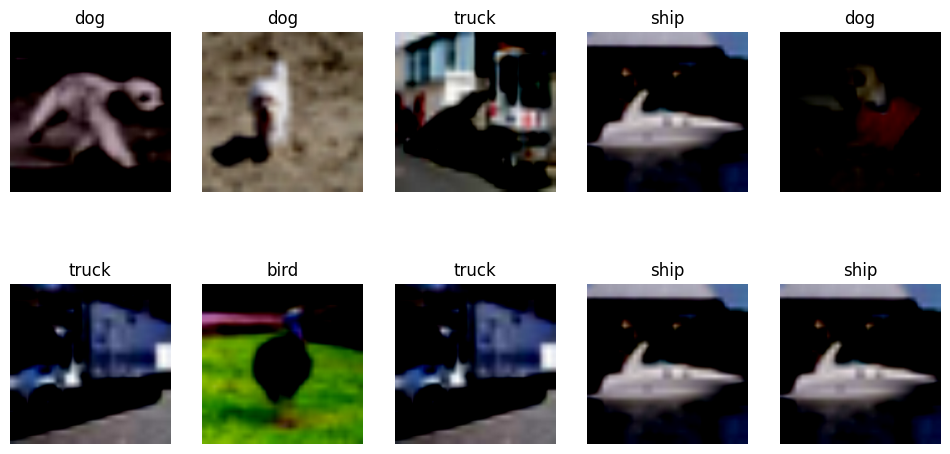

In [10]:
figure = plt.figure(figsize=(12,6))
rows,cols = 2,5
for i in range(1,rows*cols + 1):
    idx = torch.randint(len(images),size=(1,)).item()
    X,Y = images[idx].permute(1,2,0),labels[idx].item()
    img,label = X.to('cpu'),Y
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [11]:
def train_epoch(model,data_loader,loss_fn,optimiser,device):
    model.train()
    total_loss = 0
    i = 0
    for (X,Y) in data_loader:
        X,Y = X.to(device),Y.to(device)
        predictions = model(X)
        loss = loss_fn(predictions,Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        i += 1
        if i % 32 == 0:
            print("|",end="")
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"\t\tloss : {avg_loss}",end="")

In [12]:
def getAccuracy(predictions,Y):
    return torch.mean((predictions == Y).type(torch.float)).item() * 100

In [13]:
def test(model,data_loader,device,testing=True):
    accuracy_total = 0
    for (X,Y) in data_loader:
        X,Y = X.to(device),Y.to(device)
        predictions = predict(model,X)
        accuracy_total += getAccuracy(predictions,Y)
        accuracy = accuracy_total / len(data_loader)
    print(f"\n{'test' if testing else 'train'} accuracy : {accuracy:.2f}%",end="")

In [14]:
def train(model,train_data_loader,loss_fn,optimiser,device,epochs,scheduler,test_data_loader=None):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_epoch(model,train_data_loader,loss_fn,optimiser,device)
        scheduler.step()
        print("\n--------------------------")
    print("Done")

In [15]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.9MB/s]


In [38]:
def predict(model,input_data):
    model.eval()
    with torch.no_grad():
        A = model(input_data)
        predictions = A.argmax(dim=1)
    return predictions

In [17]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [18]:
model = model.to(device)

In [19]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimiser,step_size=5,gamma=0.5)
EPOCHS = 20

In [26]:
train(model,train_loader,loss_fn,optimiser,device,EPOCHS,step_lr_scheduler)

Epoch 1
||||||||||||||||||||||||		loss : 0.5148126292411629
--------------------------
Epoch 2
|||||||||||||||||||||||||		loss : 0.516656191776628
--------------------------
Epoch 3
||||||||||||||||||||||||		loss : 0.5113333103525669
--------------------------
Epoch 4
||||||||||||||||||||||||		loss : 0.5084562792116419
--------------------------
Epoch 5
||||||||||||||||||||||||		loss : 0.5121403260113638
--------------------------
Epoch 6
||||||||||||||||||||||||		loss : 0.5088447663942566
--------------------------
Epoch 7
||||||||||||||||||||||||		loss : 0.5100715413232288
--------------------------
Epoch 8
||||||||||||||||||||||||		loss : 0.5086506446228003
--------------------------
Epoch 9
||||||||||||||||||||||||		loss : 0.5068957317630043
--------------------------
Epoch 10
||||||||||||||||||||||||		loss : 0.5093393124201718
--------------------------
Epoch 11
||||||||||||||||||||||||		loss : 0.5093007888597296
--------------------------
Epoch 12
||||||||||||||||||||||||		loss :

In [27]:
test(model,train_loader,device,testing=False)
test(model,test_loader,device,testing=True)


train accuracy : 83.45%
test accuracy : 81.70%

### Predictions

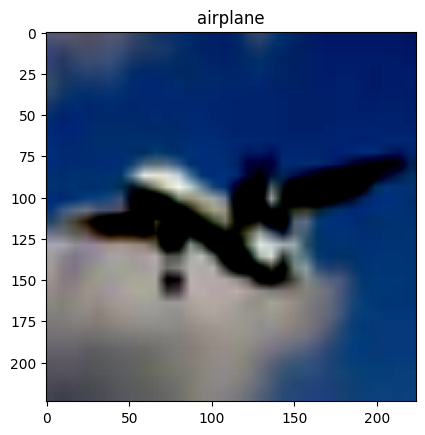

In [50]:
idx = torch.randint(len(test_dataset),size=(1,)).item()
X = test_dataset[idx][0].reshape(1,3,224,224).to(device)
prediction = predict(model,X).item()
img = test_dataset[idx][0].permute(1,2,0)
plt.title(LABEL_MAP[prediction])
plt.imshow(img)
plt.show()

In [51]:
MODEL_PATH = "/kaggle/working/cifar10_model.pt"

In [52]:
torch.save(model.state_dict(),MODEL_PATH)